In [ ]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
!pip install keras-self-attention
from keras_self_attention import SeqSelfAttention
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation

# Read Data
df = pd.read_csv("X.csv")

# Data Cleaning
df.isnull()
df.dropna(inplace=True)

# Data Preparation
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date")
df.set_index('Date', inplace=True)
selected_columns = ['Close']
df_selected = df[selected_columns].copy()
df_selected['Close'] = df_selected['Close'].astype(float)

# Scaling data
scaler = MinMaxScaler()
df_selected['Close'] = scaler.fit_transform(df_selected[['Close']])

# Window Size dan Horizon
window_size = 5
horizon = 1

# Input dan Output
def input_output(dataset, window_size=5, horizon=1):
    X, y = [], []
    for i in range(len(dataset) - window_size - horizon + 1):
        a = dataset[i:(i + window_size), 0]
        X.append(a)
        y.append(dataset[i + window_size + horizon - 1, 0])
    return np.array(X), np.array(y)


  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=b231f367846d443033e0199fa478023b4074ae41d42ac3a010a3a2c559d49b16
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
# Split Data
train_size = int(len(df_selected) * 0.8)
val_size = int(len(df_selected) * 0.1)
test_size = len(df_selected) - train_size - val_size

train = df_selected[:train_size]
val = df_selected[train_size:train_size+val_size]
test = df_selected[train_size+val_size:]

X_train, y_train = input_output(train.values, window_size, horizon)
X_val, y_val = input_output(val.values, window_size, horizon)
X_test, y_test = input_output(test.values, window_size, horizon)

# Reshape Data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)



In [ ]:
# Model LSTM
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=128, activation='relu', input_shape=(window_size, 1), return_sequences = False))
model_LSTM.add(Dense(units=horizon))
model_LSTM.compile(optimizer='adam', metrics='mean_absolute_error', loss='mean_squared_error')
model_LSTM.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
hist_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
95/95 [==============================] - 3s 12ms/step - loss: 0.0119 - mean_absolute_error: 0.0589 - val_loss: 9.7862e-05 - val_mean_absolute_error: 0.0082
Epoch 2/20
95/95 [==============================] - 1s 9ms/step - loss: 3.6629e-04 - mean_absolute_error: 0.0117 - val_loss: 6.5370e-05 - val_mean_absolute_error: 0.0061
Epoch 3/20
95/95 [==============================] - 1s 8ms/step - loss: 3.4522e-04 - mean_absolute_error: 0.0113 - val_loss: 6.4721e-05 - val_mean_absolute_error: 0.0061
Epoch 4/20
95/95 [==============================] - 1s 8ms/step - loss: 3.5863e-04 - mean_absolute_error: 0.0116 - val_loss: 1.0688e-04 - val_mean_absolute_error: 0.0086
Epoch 5/20
95/95 [==============================] - 1s 15ms/step - loss: 3.6731e-04 - mean_absolute_error: 0.0121 - val_loss: 1.0766e-04 - val_mean_absolute_error: 0.0082
Epoch 6/20
95/95 [==============================] - 1s 15ms/step - loss: 3.4486e-04 - mean_absolute_error: 0.0114 - val_loss: 6.1083e-05 - val_mean_abso

In [ ]:
# Adding Sequential Self-Attention
model_LSTM_SelfAttention = Sequential()
model_LSTM_SelfAttention.add(LSTM(128,return_sequences=True))
model_LSTM_SelfAttention.add(SeqSelfAttention(attention_activation='softmax'))
model_LSTM_SelfAttention.add(Flatten())
model_LSTM_SelfAttention.add(Dense(horizon))
model_LSTM_SelfAttention.compile(metrics = 'mean_absolute_error',loss='mean_squared_error', optimizer='adam')


In [ ]:
hist_LSTM_SelfAttention = model_LSTM_SelfAttention.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


95/95 [==============================] - 7s 36ms/step - loss: 0.0094 - mean_absolute_error: 0.0527 - val_loss: 8.5537e-05 - val_mean_absolute_error: 0.0071
Epoch 2/20
95/95 [==============================] - 2s 22ms/step - loss: 5.2269e-04 - mean_absolute_error: 0.0144 - val_loss: 9.7707e-05 - val_mean_absolute_error: 0.0079
Epoch 3/20
95/95 [==============================] - 2s 24ms/step - loss: 5.0834e-04 - mean_absolute_error: 0.0138 - val_loss: 8.6528e-05 - val_mean_absolute_error: 0.0070
Epoch 4/20
95/95 [==============================] - 2s 21ms/step - loss: 4.9001e-04 - mean_absolute_error: 0.0136 - val_loss: 9.3558e-05 - val_mean_absolute_error: 0.0076
Epoch 5/20
95/95 [==============================] - 2s 24ms/step - loss: 4.8768e-04 - mean_absolute_error: 0.0135 - val_loss: 8.6503e-05 - val_mean_absolute_error: 0.0070
Epoch 6/20
95/95 [==============================] - 2s 21ms/step - loss: 4.6805e-04 - mean_absolute_error: 0.0129 - val_loss: 8.5734e-05 - val_mean_absolute_err

Pada LSTM, sequential self attention menghitung attention score antara hidden states dari encoder dan decoder. Attention score akan digunakan untuk membuat suatu context vector, yang merupakan weighted sum dari hidden states encoder, dan akan diberikan kepada decoder sebagai input tambahan. Vektor konteks akan membantu decoder untuk mengakes informasi yang penting dan relevan dari decoder dan menghasilkan output yang lebih akurat.

Sumber : https://www.linkedin.com/advice/1/what-advantages-challenges-using-attention#:~:text=Attention%20mechanisms%20enhance%20LSTM%20sequence,encoder%20and%20decoder%20hidden%20states.

In [ ]:
mse_LSTM, mae_LSTM = model_LSTM.evaluate(X_test, y_test)
print("MSE LSTM :", mse_LSTM)
print("MAE LSTM :", mae_LSTM)

12/12 [==============================] - 0s 7ms/step - loss: 5.1552e-04 - mean_absolute_error: 0.0142
MSE LSTM : 0.0005155229009687901
MAE LSTM : 0.014233245514333248


In [ ]:
mse_LSTM_SelfAttention, mae_LSTM_SelfAttention = model_LSTM_SelfAttention.evaluate(X_test, y_test)
print("MSE LSTM Self Attention :", mse_LSTM_SelfAttention)
print("MAE LSTM Self Attention :", mae_LSTM_SelfAttention)

12/12 [==============================] - 0s 6ms/step - loss: 6.2817e-04 - mean_absolute_error: 0.0149
MSE LSTM Self Attention : 0.0006281657260842621
MAE LSTM Self Attention : 0.014921852387487888


Berdasarkan dari hasil MSE dan MAE yang didapatkan, model LSTM tanpa menggunakan Self Attention merupakan model yang lebih baik karena nilai MSE dan MAE yang lebih rendah dibandingkan dengan model LSTM dengan menggunakan Self Attention.

12/12 [==============================] - 1s 5ms/step


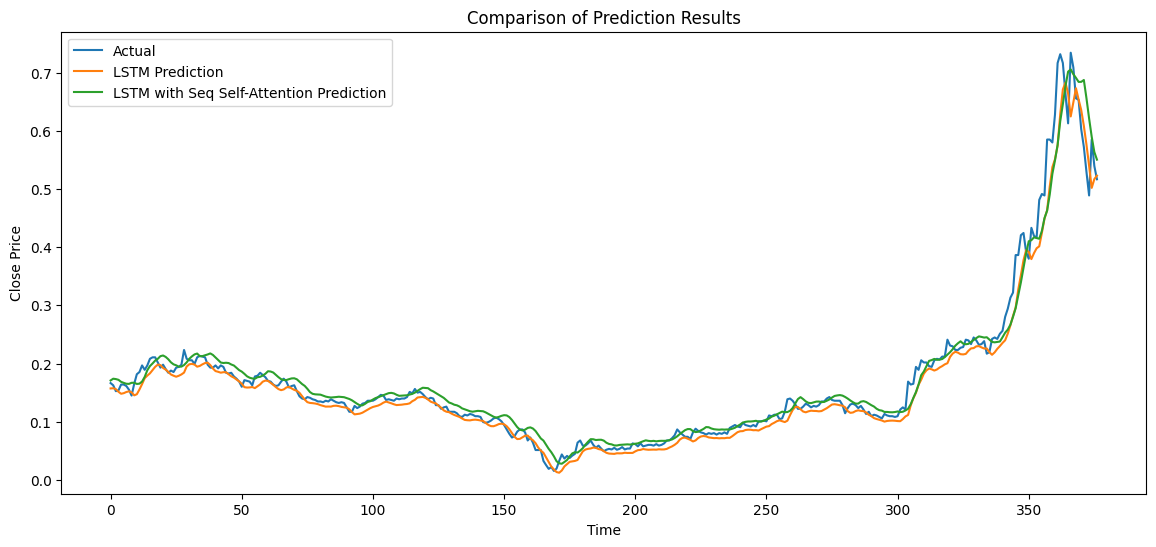

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_pred_LSTM = model_LSTM.predict(X_test)
y_pred_LSTM_SelfAttention = model_LSTM_SelfAttention.predict(X_test)

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_LSTM, label='LSTM Prediction')

plt.plot(y_pred_LSTM_SelfAttention, label='LSTM with Seq Self-Attention Prediction')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Comparison of Prediction Results')
plt.legend()
plt.show()
